# Feature Engineering and Model selection
> This notebook deals with feature selection, extraction and Transformation, and later selecting some machine learning algorithms that perfoms better with default hyperparameters. We will then perform parameter tuning to select a best performing model, and finally train a final model

In [2]:
""" importing packages """

""" general computing packages """
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

""" packages for data preperation and transformations"""
import sklearn.impute as sk_imputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


""" packages for machine learning algorithms """
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

""" packages for model metrics and model tuning and selection """
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, learning_curve, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

In [3]:
""" 
plotting learning curves - Generate 3 plots: the test and training learning curve, the training samples vs fit times curve, the fit times vs score curve.
the scoring used here is MAE.
"""

def plot_learning_curve(
    estimator,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 5),
    title = 'Learning_curve',
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes,train_scores,test_scores,fit_times,score_time = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


### From EDA - following insights were gained

- missing values on all columns are less than 3% individually
- numerical columns - engine_cc(slight left skew), power_bhp(slight left skew), km-driven (heavy left skew), and mileage(almost normal), seat kept as integer variable even though it can be categorical
- categorical columns - Company(freq combine <100), fuel(petrol,diesel,others), seller_type(ind, dealers combined),transmission(man,auto - no changes), owner(single,second,third,others)
- Torque and Car columns are unnecessary ( torque has very high correlation with power, Car has too many categories and it is efficiently represented in Company column)
- Mileage column has 2 different units - feature transformation may be necessary here (price per km)


### Algorithms considered to model this data- 
1. Linear Regression (Ridge/l1 penalty)
2. Polynomial regression (optional)  
3. Random Forest regressor (ensamble learning)
4. ADABoost regressor (Boosting technique)
5. XG-Boost regressor (Boosting technique)

# Feature Engineering 

> Operations done -

- drop torque and Car columns
- Fill NaN values of (mileage, engine_cc, max_power_bhp, seats) using frequently seen values for each car type (since all the above features are specific to a car model)
- checking and typecasting features into relevent datatypes
- Create feature price_per_km inplace of mileage
- Transform/Scale (Box_Cox transformer) numerical variables to better fit normal curve(optional)
- encoding categorical features 

In [4]:
""" import cleaned data """

data = pd.read_csv("carprice_data_cleaned.csv", na_values=['0']).drop(columns=['torque'])


In [5]:
""" Checking datatypes of columns"""
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company        8128 non-null   object 
 1   Car            8128 non-null   object 
 2   year           8128 non-null   int64  
 3   km_driven      8128 non-null   float64
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7890 non-null   float64
 9   engine_cc      7907 non-null   float64
 10  max_power_bhp  7906 non-null   float64
 11  seats          7907 non-null   float64
 12  selling_price  8128 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 825.6+ KB


In [6]:
""" creates a dataframe  - """

def get_mostseen(data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.dropna()

    #mode on categorical columns
    mostseen_categ = df[df.select_dtypes(include=['object']).columns.tolist()].groupby(by="Car").agg(lambda x:x.value_counts(dropna=True).index[0])

    #median on numerical columns
    n_cols = ['Car']+ df.select_dtypes(include=np.number).columns.tolist()
    mostseen_numerics=df[n_cols].drop(columns='selling_price').groupby(by='Car').median()
    
    #join both the tables
    whole_df = mostseen_categ.merge(right=mostseen_numerics, how='outer', left_on='Car', right_on='Car' ).reset_index()

    return whole_df

In [7]:
mostseen_df = get_mostseen(data)

mostseen_df.to_csv('mostseen.csv')

In [8]:
""" imputer function - imputes NaN values by mostseen values as taken from the original data"""

def NullImpute_MostSeen(data:pd.DataFrame, most_seen_df:pd.DataFrame, imputer_columns:list) -> pd.DataFrame:
    #creating copy, to not alter the actual dataframe
    data_copy = data.copy(deep=True)
    #stripping trailing whitespaces (to be safe)
    data_copy['Car'] = data_copy['Car'].str.strip()
    most_seen_df['Car'] = most_seen_df['Car'].str.strip()

    #imputing the columns one by one
    for a_column in imputer_columns:
        mapper = dict(most_seen_df[['Car', a_column]])

        #np.where() to mask non-null values and map it over the mostseen data
        data_copy[a_column] = np.where(data_copy[a_column].isnull(), data_copy['Car'].map(most_seen_df.set_index('Car')[a_column]), data_copy[a_column])
    
    return data_copy


In [9]:
"""
Imputing the NaN in data then dropping any remaining NaN as nothing can be done over that
"""

data_imputed = NullImpute_MostSeen(data, mostseen_df, ['engine_cc','mileage','max_power_bhp','seats']).dropna()

data_imputed.shape

(8036, 13)

In [10]:
data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8036 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company        8036 non-null   object 
 1   Car            8036 non-null   object 
 2   year           8036 non-null   int64  
 3   km_driven      8036 non-null   float64
 4   fuel           8036 non-null   object 
 5   seller_type    8036 non-null   object 
 6   transmission   8036 non-null   object 
 7   owner          8036 non-null   object 
 8   mileage        8036 non-null   float64
 9   engine_cc      8036 non-null   float64
 10  max_power_bhp  8036 non-null   float64
 11  seats          8036 non-null   float64
 12  selling_price  8036 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 878.9+ KB


In [11]:
""" decreasing cardinality by grouping rare categories into - others"""

def freq_category_imp(data:pd.DataFrame, column:str, categories:list, replacer ='others') -> pd.DataFrame:
    #replace if category not in the categories list
    data.loc[~data[column].isin(categories), column]= replacer
    return data

In [12]:
""" 
Applying cardinality reduction over the following columns - 
- fuel
- seller_type
- owner
- Company 

"""

data_imputed = freq_category_imp(data_imputed, "fuel", ["Diesel","Petrol"] )

data_imputed = freq_category_imp(data_imputed, "seller_type", ['Individual'],replacer="Dealers")

data_imputed = freq_category_imp(data_imputed, "owner", ['First Owner', 'Second Owner', 'Third Owner'])

#setting a lower count threshold for categories in column-Company and getting category names
value_counts = data_imputed['Company'].value_counts().reset_index()
categs = list(value_counts[value_counts['Company']>100]['index'])

data_imputed = freq_category_imp(data_imputed, "Company", categs, replacer='others' )

In [13]:
""" correcting datatypes of some columns and dropping column -Car since imputation is done"""

data_imputed['seats'] = data_imputed['seats'].astype(np.int64)
data_imputed['year'] = data_imputed['year'].astype(np.int64)
data_imputed['km_driven'] = data_imputed['km_driven'].astype(np.float64)
data_imputed.drop(columns='Car', inplace=True)
data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8036 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company        8036 non-null   object 
 1   year           8036 non-null   int64  
 2   km_driven      8036 non-null   float64
 3   fuel           8036 non-null   object 
 4   seller_type    8036 non-null   object 
 5   transmission   8036 non-null   object 
 6   owner          8036 non-null   object 
 7   mileage        8036 non-null   float64
 8   engine_cc      8036 non-null   float64
 9   max_power_bhp  8036 non-null   float64
 10  seats          8036 non-null   int64  
 11  selling_price  8036 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 816.2+ KB


In [14]:
""" price per km transformer - converts mileage to cost per kilometer based on fuel type 

Cost(INR) of a liter/kg of fuel considered- [diesel=88, petrol=102, others=85]

Cannot use this transformer with -ColumnTransformer yet

retained the original column name - Not to get confused in later operations
"""
class MileagetoCostperKmTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, diesel = 88, petrol = 102, others = 85 ) -> None:
        self.diesel = diesel
        self.petrol = petrol
        self.others = others

    def fit(self, X : pd.DataFrame, y=None):
        return self

    def transform(self, X : pd.DataFrame, y=None):

        conditions = [  
                        X['fuel']=="Diesel",
                        X['fuel']=="Petrol"
                        ]
        choices = [
                        self.diesel*(1/X['mileage']),
                        self.petrol*(1/X['mileage'])
        ]
        X["mileage"] = np.select(conditions, choices, default= self.others*(1/X['mileage']))

        return X

In [15]:
mileage_transform = MileagetoCostperKmTransformer()

data_imputed = mileage_transform.fit_transform(data_imputed)

In [66]:

data_imputed.to_csv('cleaned_imputed_data.csv', index=False)

# Feature Encoding 
> Steps Done - 
1.  Encoding categorical variables using OneHotEncoder
2.  Transforming numerical variables using Box-Cox Transformation (also handles standardization), since the numerical features are slightly left skewwed (not necessary for RandomForest, ADABoost - but doesnot hurt if standardized)

In [22]:
""" train test split first before any other transformations """

features = data_imputed.drop(columns=['selling_price'], inplace=False)
label = data_imputed['selling_price']
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                                label, train_size=0.8)





In [23]:
""" 
Column Transformer - only categorical encoding on categorical variables

Use for Random forest and ADABoost 
"""

cat_encoded = ColumnTransformer( transformers= [
    ('on_categorical_vars',OneHotEncoder(drop='first', sparse=False),['Company','fuel','owner']),
    ('binary_categories', OneHotEncoder(drop='if_binary', sparse=False), ['transmission','seller_type'])],
    remainder='passthrough')

X_trans = cat_encoded.fit_transform(X_train)

X_test_trans =  cat_encoded.transform(X_test)


In [ ]:
cat_encoded.get_feature_names_out()


In [25]:
"""
Column Transformer - categorical encoding and scaling and transformation of numeric variables

use for regression and any other distance based algorithms
"""

transform_all = ColumnTransformer(transformers= [ 
    ('num_transform', PowerTransformer(copy=False), ['year','km_driven','mileage','engine_cc','max_power_bhp']),
    ('categorical_enc',OneHotEncoder(drop='first', sparse=False),['Company','fuel','owner']),
    ('transmission_binary', OneHotEncoder(drop='if_binary', sparse=False), ['transmission','seller_type'])    
], remainder='passthrough', n_jobs=-1)

X_trans_all = transform_all.fit_transform(X_train)

X_test_trans_all = transform_all.transform(X_test)



In [58]:
features_names= transform_all.get_feature_names_out(X_train.columns)

# Model Selection

> Models under consideration - Regression, Random Forest, ADABoost, XgBoost


### Ridge Regression

In [29]:
"""  Ridge regression -
learning rate = 0.001, with early-stopping, 
"""

RidgeRegr = SGDRegressor(penalty='l1', alpha=0.0001, early_stopping = True)

RidgeRegr.fit(X=X_trans_all, y=y_train)


SGDRegressor(early_stopping=True, penalty='l1')

R^2 :  0.6632344859186066
MAE : 276739.30319685163
RMSE: 474233.04318806936
explained_var: 0.664488226446966


<module 'matplotlib.pyplot' from 'C:\\Users\\U6080693\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

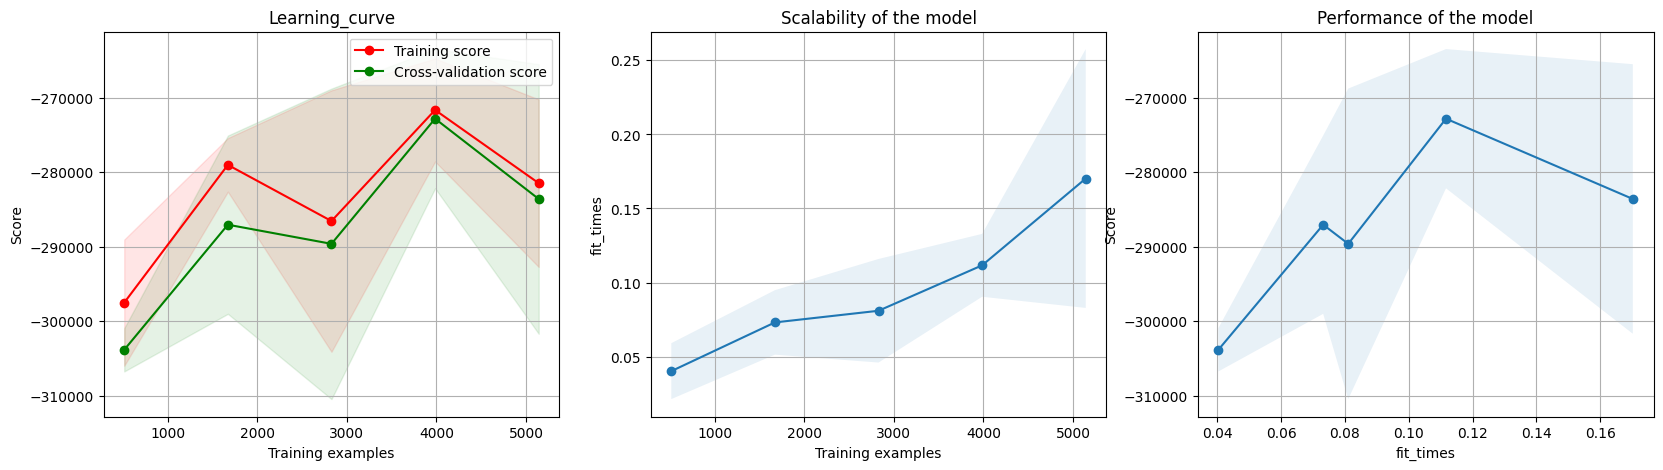

In [30]:
"""
Metrics of evaluation of Ridge Regression - 
- r2 score
- Mean Absolute error (MAE)
- Root Mean Squared Error (RMSE)
- explained variance

learning curves are plotted using MAE
"""

y_pred = RidgeRegr.predict(X_test_trans_all)
print("R^2 : ", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
print('explained_var:',explained_variance_score(y_test,y_pred))

pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})

plot_learning_curve(RidgeRegr, X_trans_all, y_train, n_jobs=-1)

### Random Forest Regressor

In [35]:
""" 
Random Forest regressor -
trees = 200, tree_depth=8

"""

randForest = RandomForestRegressor(n_estimators=200, max_depth=8, verbose=1)

randForest.fit(X = X_trans, y= y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.0s finished


RandomForestRegressor(max_depth=8, n_estimators=200, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


R^2 :  0.968288294647956
MAE : 85245.58063900605
RMSE: 145525.06566821047
explained_var: 0.9682886136619784


<module 'matplotlib.pyplot' from 'C:\\Users\\U6080693\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

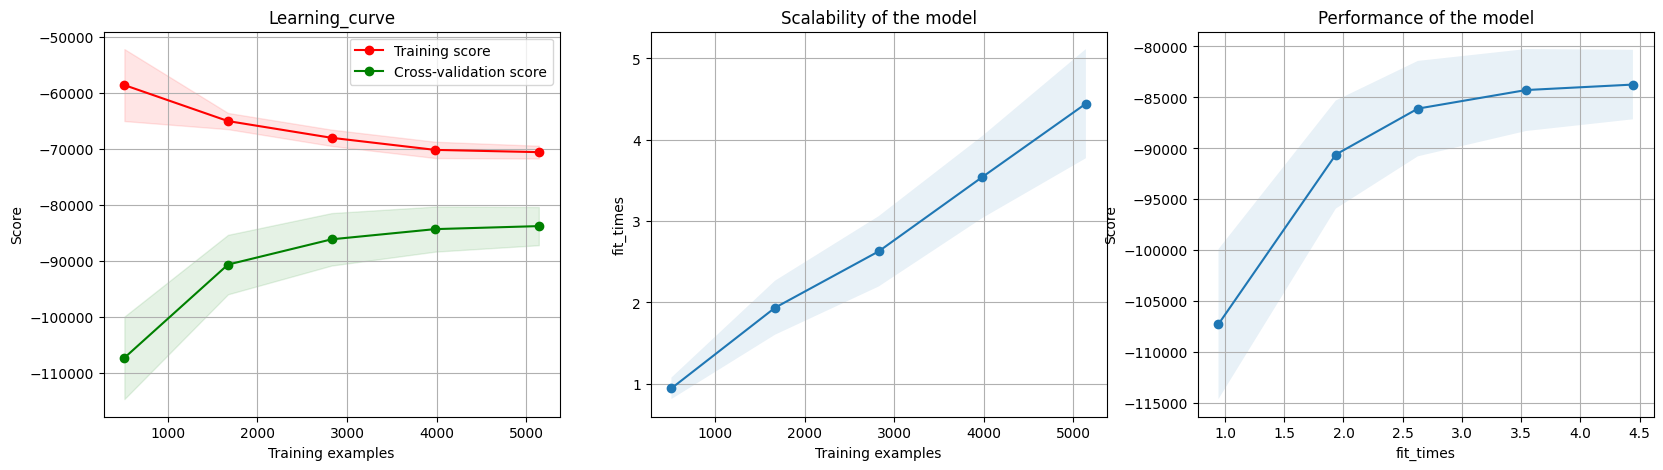

In [37]:
"""
Metrics of evaluation of Random Forest - 
- r2 score
- Mean Absolute error (MAE)
- Root Mean Squared Error (RMSE)
- explained variance

learning curves are plotted using MAE
"""

y_pred_rf = randForest.predict(X_test_trans)
print("R^2 : ", r2_score(y_test, y_pred_rf))
print("MAE :", mean_absolute_error(y_test,y_pred_rf))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('explained_var:',explained_variance_score(y_test,y_pred_rf))

pd.DataFrame({'y_test':y_test, 'y_pred':y_pred_rf})

plot_learning_curve(randForest, X_trans, y_train, n_jobs=-1)

### ADABoost Regressor

In [46]:
"""
AdaBoost regressor - 
decision_stump depth=5, sequence=300, lr=0.01
"""

ADAReg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),n_estimators=300, learning_rate=0.2)

ADAReg.fit(X= X_trans_all, y= y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                  learning_rate=0.2, n_estimators=300)

R^2 :  0.9448720108602391
MAE : 147266.04498890886
RMSE: 191873.0949261608
explained_var: 0.9559105606712449


<module 'matplotlib.pyplot' from 'C:\\Users\\U6080693\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

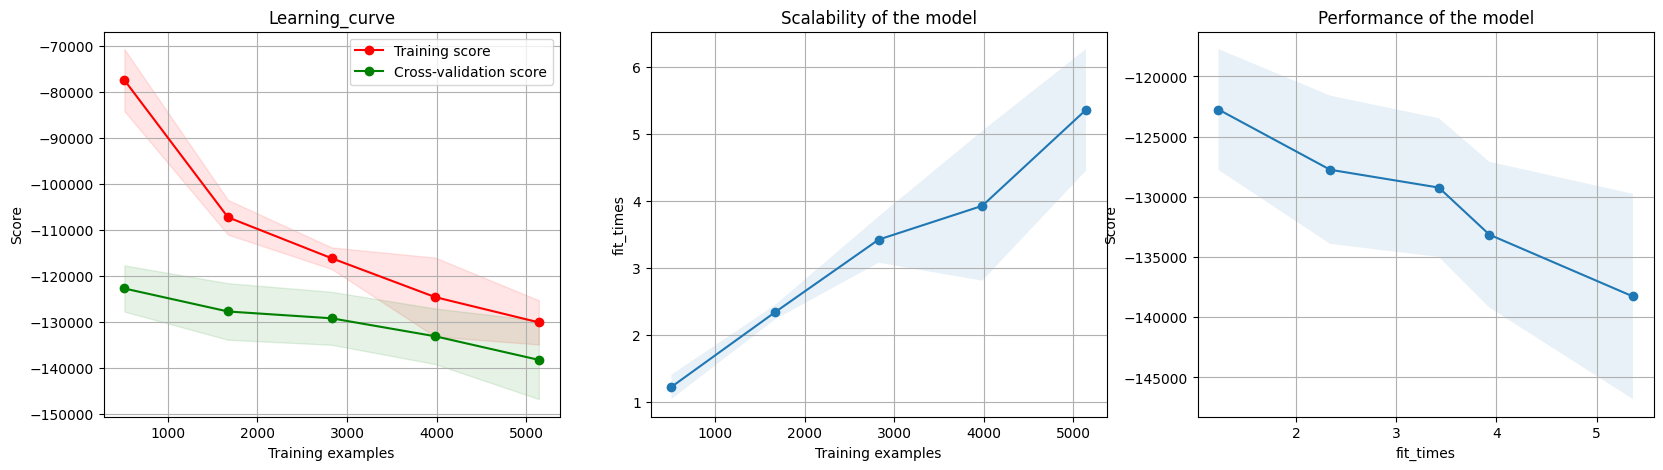

In [47]:
"""
Metrics of evaluation of ADABoost - 
- r2 score
- Mean Absolute error (MAE)
- Root Mean Squared Error (RMSE)
- explained variance

learning curves are plotted using MAE
"""


y_pred_ada = ADAReg.predict(X_test_trans_all)
print("R^2 : ", r2_score(y_test, y_pred_ada))
print("MAE :", mean_absolute_error(y_test,y_pred_ada))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_ada)))
print('explained_var:',explained_variance_score(y_test,y_pred_ada))

pd.DataFrame({'y_test':y_test, 'y_pred':y_pred_ada})

plot_learning_curve(ADAReg, X_trans_all, y_train, n_jobs=-1)

### XGBoost Regressor

In [48]:
"""
XgBoost regressor -
estimators=300, max_depth=8, lr=0.25
"""
xgb = XGBRegressor(objective="reg:squarederror", n_estimators=300, n_jobs=-1, learning_rate = 0.25, max_depth=8)

xgb.fit(X_trans_all, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

R^2 :  0.9775006276144209
MAE : 62598.95733490749
RMSE: 122578.19078247774
explained_var: 0.9775094634438364


<module 'matplotlib.pyplot' from 'C:\\Users\\U6080693\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

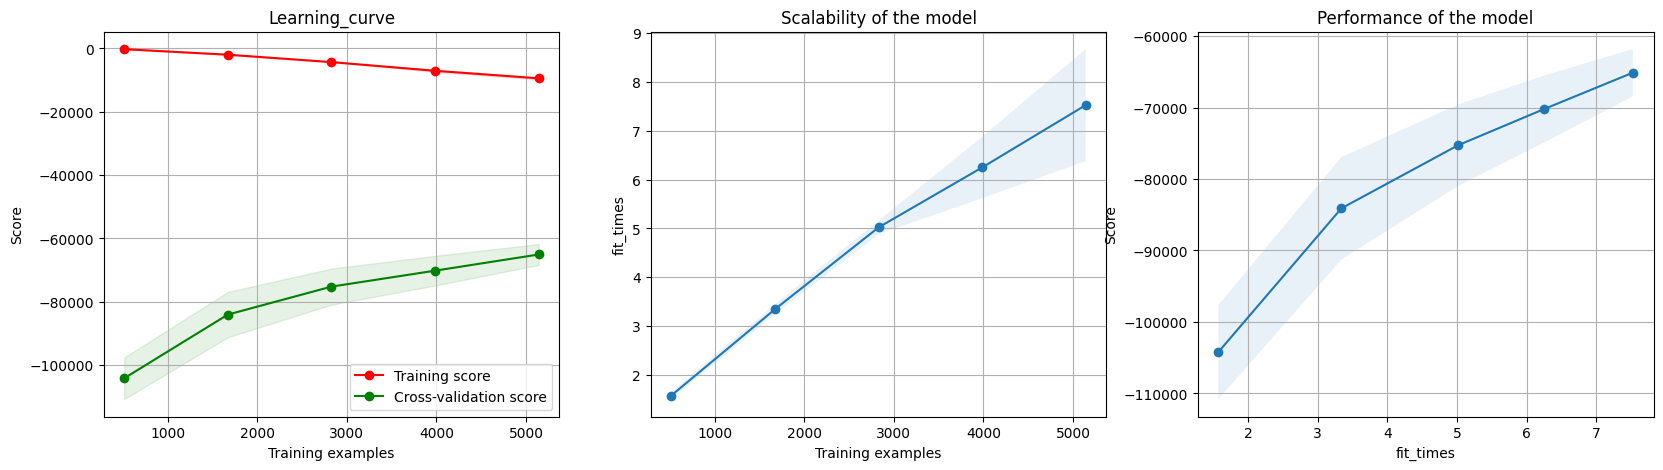

In [49]:
"""
Metrics of evaluation of XgBoost - 
- r2 score
- Mean Absolute error (MAE)
- Root Mean Squared Error (RMSE)
- explained variance

learning curves are plotted using MAE
"""

y_pred_xgb = xgb.predict(X_test_trans_all)
print("R^2 : ", r2_score(y_test, y_pred_xgb))
print("MAE :", mean_absolute_error(y_test,y_pred_xgb))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('explained_var:',explained_variance_score(y_test,y_pred_xgb))

pd.DataFrame({'y_test':y_test, 'y_pred':y_pred_xgb})

plot_learning_curve(xgb, X_trans_all, y_train, n_jobs=-1)

# Conclusion

> RandomForest Regressor and XgBoost Regressor have promising initial results.

We will select these two and do some more model evaluation using different parameters to have better idea of their performance

# Final Model evaluation

> we will use cross_validation to further evaluate these two models and later tune hyperparameter using gridSearchCV

In [100]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import RobustScaler

In [90]:
data = pd.read_csv('cleaned_imputed_data.csv')

In [91]:
""" train test split first before any other transformations """

features = data_imputed.drop(columns=['selling_price'], inplace=False)
label = data_imputed['selling_price']
"""
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                                label, train_size=0.8)
"""



'\nX_train, X_test, y_train, y_test = train_test_split(features, \n                                                                label, train_size=0.8)\n'

In [101]:
"""
Column Transformer - categorical encoding and scaling and transformation of numeric variables

use for regression and any other distance based algorithms
"""

pre_processing = ColumnTransformer(transformers= [ 
    ('winsorization', RobustScaler(with_centering=False, with_scaling=False, quantile_range=(5.0,95.0), copy=False) ,['km_driven']),
    ('num_transform', PowerTransformer(copy=False), ['year','km_driven','mileage','engine_cc','max_power_bhp']),
    ('categorical_enc',OneHotEncoder(drop='first', sparse=False),['Company','fuel','owner']),
    ('transmission_binary', OneHotEncoder(drop='if_binary', sparse=False), ['transmission','seller_type'])    
], remainder='passthrough', n_jobs=-1)


In [102]:
scores = ['neg_mean_absolute_error','explained_variance','r2']

### Random Forest Regressor

In [103]:
RandForest = RandomForestRegressor(n_estimators=200, max_depth=8, verbose=2, n_jobs=-1)

RandForestPipe = make_pipeline(
                                pre_processing,
                                RandForest,
                                verbose=False)

In [104]:
cross_validation = cross_validate(RandForestPipe, features, label, scoring=scores, cv=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 185 out of 200 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 

In [106]:
cross_validation

{'fit_time': array([6.94090724, 2.01363564, 1.91732407, 1.3993814 , 1.83338261,
        1.86937284, 2.05823731, 1.57618499, 1.60434937, 1.81027818]),
 'score_time': array([0.06663966, 0.06884313, 0.06979823, 0.12057829, 0.11846972,
        0.14505601, 0.16522074, 0.10776758, 0.11993623, 0.1069746 ]),
 'test_neg_mean_absolute_error': array([-85288.65977257, -70949.59579589, -88147.46119599, -80333.28577404,
        -73479.45249613, -89822.88258237, -89874.91529864, -80734.34329707,
        -74590.03574429, -99583.88147479]),
 'test_explained_variance': array([0.93135936, 0.98313254, 0.9553055 , 0.96424299, 0.97455922,
        0.97673234, 0.94059215, 0.94120057, 0.97800202, 0.94996717]),
 'test_r2': array([0.9313538 , 0.98313235, 0.95526336, 0.96377567, 0.97450346,
        0.97653341, 0.94043876, 0.94119794, 0.97782362, 0.94982994])}

### XgBoost Regressor

In [107]:
xgboost = XGBRegressor(objective="reg:squarederror", n_estimators=300, n_jobs=-1, learning_rate = 0.25, max_depth=8)

XgBoostPipe = make_pipeline(
                                pre_processing,
                                xgboost,
                                verbose=False)

In [108]:
cross_validation = cross_validate(XgBoostPipe, features, label, scoring=scores, cv=10)

In [109]:
cross_validation

{'fit_time': array([2.0484848 , 2.54104924, 2.31897712, 2.26317739, 2.15935349,
        2.18020463, 2.08778405, 2.11090398, 2.1698122 , 2.12982988]),
 'score_time': array([0.02991939, 0.02892232, 0.02897763, 0.03135896, 0.03122735,
        0.02749968, 0.02891469, 0.02808738, 0.02801156, 0.02721524]),
 'test_neg_mean_absolute_error': array([-64801.46890183, -52849.24374951, -63439.17015751, -63216.45308127,
        -56598.56135825, -66173.88118733, -75488.94030929, -57545.00548237,
        -63301.98758075, -75895.40783585]),
 'test_explained_variance': array([0.93214016, 0.99008137, 0.9695121 , 0.97220824, 0.98090389,
        0.97962874, 0.91154535, 0.95798091, 0.98273763, 0.95894598]),
 'test_r2': array([0.93212478, 0.99007343, 0.96946086, 0.97201409, 0.98090207,
        0.97960292, 0.91128977, 0.95797949, 0.98269438, 0.95883176])}

# Final Conclusion 

- seeing the cross validation scores it is evident that XgBoost and Random Forest regressor perform well on this dataset. It iis time to tune hyperparameters for both models and see which suits the best.